# 0.0 Imports


In [128]:
import pandas as pd
import numpy as np
import inflection

import seaborn as sns
import matplotlib.pyplot as plt
import psycopg2 as pg


from sklearn import model_selection as ms

## 0.1 Helper Functions

## 0.2 Load Data

In [129]:
data_train_raw = pd.read_csv('../inputs/train.csv')
data_test_raw = pd.read_csv('../inputs/test.csv')

## 0.3 Rename Columns

In [130]:
#old columns
cols_old = list(data_train_raw.columns)
#creating function
rename_columns = lambda x: inflection.underscore(x)
#new columns
cols_new = list(map(rename_columns, cols_old))
#renaming columns 
data_train_raw.columns = cols_new

## 0.3 Split dataset

In [131]:
data_train_raw

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0
381105,381106,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0
381106,381107,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0
381107,381108,Female,68,1,14.0,0,> 2 Years,Yes,44617.0,124.0,74,0


In [132]:
X = data_train_raw.drop('response', axis=1)
y = data_train_raw[['response']]


In [133]:
X_train, X_test, y_train, y_test = ms.train_test_split(X,y, test_size=0.3, random_state=42)

In [134]:
#train dataset
df_train = pd.concat([X_train, y_train], axis=1)

#test dataset
df_test = pd.concat([X_test, y_test], axis=1)

In [135]:
df_train.sample(5)

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
300155,300156,Male,44,1,33.0,0,1-2 Year,Yes,28605.0,124.0,139,0
127075,127076,Female,21,1,8.0,0,< 1 Year,Yes,32065.0,152.0,216,0
224015,224016,Male,60,1,29.0,0,1-2 Year,Yes,37376.0,31.0,274,0
130874,130875,Male,29,1,27.0,0,< 1 Year,Yes,67203.0,152.0,206,0
68928,68929,Female,25,1,28.0,1,< 1 Year,No,49789.0,152.0,198,0


# 1.0 Data Description

In [136]:
df1 = df_train.copy()


- 'id': 	'Unique ID for the customer',
- 'Gender': 	'Gender of the customer',
- 'Age': 	'Age of the customer',
- 'Driving_License': 	'0 : Customer does not have DL, 1 : Customer already has DL',
- 'Region_Code': 	'Unique code for the region of the customer',
- 'Previously_Insured': 	'1 : Customer already has Vehicle Insurance, 0 : Customer doesnt have Vehicle Insurance',
- 'Vehicle_Age': 	'Age of the Vehicle',
- 'Vehicle_Damage': 	'1 : Customer got his/her vehicle damaged in the past. 0 : Customer didnt get his/her vehicle damaged in the past.',
- 'Annual_Premium': 	'The amount customer needs to pay as premium in the year',
- 'Policy_Sales_Channel': 	'Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.',
- 'Vintage': 	'Number of Days, Customer has been associated with the company',
- 'Response': 	'1 : Customer is interested, 0 : Customer is not interested'}



# 1.1 Data amount

In [137]:
print('Quantidade de linhas: {}'.format(df1.shape[0]))
print('Quantidade de colunas: {}'.format(df1.shape[1]))


Quantidade de linhas: 266776
Quantidade de colunas: 12


## 1.2 Data Types

In [138]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.3 Check NaN

In [139]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.4 Descriptive Statistical

In [140]:
numerical_features = df1.select_dtypes(include=['int64', 'float64'])
categorical_features = df1.select_dtypes(exclude=['int64','float64'])

### 1.4.1 Numerical Features

In [141]:
#Têndencia central
t01 = pd.DataFrame(numerical_features.apply(np.mean)).T
t02 = pd.DataFrame(numerical_features.apply(np.median)).T
#Dispersão dos dados
d01 = pd.DataFrame(numerical_features.apply(np.min)).T
d02 = pd.DataFrame(numerical_features.apply(np.max)).T
d03 = pd.DataFrame(numerical_features.apply(lambda x: x.max() - x.min())).T
d04 = pd.DataFrame(numerical_features.apply(np.std)).T
d05 = pd.DataFrame(numerical_features.apply(lambda x: x.skew())).T
d06 = pd.DataFrame(numerical_features.apply(lambda x: x.kurtosis())).T

m = pd.concat([d01,d02,d03,t01,t02,d04,d05,d06]).T.reset_index()
m.columns = ['attributes', 'min','max','range','mean','median','std','skewness','kurtosis']
m


,attributes,min,max,range,mean,median,std,skewness,kurtosis
0,id,2.0,381108.0,381106.0,190548.259180,190543.5,110059.963886,0.000641,-1.200396
1,age,20.0,85.0,65.0,38.851666,36.0,15.514605,0.668177,-0.573076
2,driving_license,0.0,1.0,1.0,0.997833,1.0,0.046496,-21.413956,456.560924
3,region_code,0.0,52.0,52.0,26.414434,28.0,13.214633,-0.118152,-0.862541
4,previously_insured,0.0,1.0,1.0,0.458310,0.0,0.498259,0.167345,-1.972010
5,annual_premium,2630.0,540165.0,537535.0,30580.218359,31680.0,17260.707353,1.862794,36.726254
6,policy_sales_channel,1.0,163.0,162.0,111.938139,128.0,54.243147,-0.896198,-0.978290
7,vintage,10.0,299.0,289.0,154.277158,154.0,83.670336,0.004882,-1.200055
8,response,0.0,1.0,1.0,0.122095,0.0,0.327395,2.308567,3.329508


### 1.4.2 Categorical Features

In [142]:
categorical_features.nunique()

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

# 2.0 Feature Engineering

In [143]:
df2 = df1.copy()

## 2.1 Hypothesis Map

1. Índice de Criminalidade da Região influência na contratação do seguro veicular
2. Clientes com maior salário contratariam o seguro veicular
3. Clientes com carros mais novos contratariam o seguro veicular
4. Pessoas mais velhas contratariam o seguro veicular
5. Clientes cujo veículo já sofreu danos contratariam o seguro veicular
6. Somente clientes habilitados contratariam o seguro veicular
7. Clientes mais antigos da seguradora contratariam o seguro veicular
8. Clientes com carros mais novos contratam o seguro veicular

# 3.0 Data Filtering

In [144]:
df3 = df2.copy()

# 4.0 Exploratory Data Analysis

In [145]:
df4 = df3.copy()
df4.sample(5)

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
364675,364676,Male,23,1,46.0,1,< 1 Year,No,30471.0,160.0,22,0
186759,186760,Female,62,1,46.0,0,1-2 Year,Yes,42971.0,124.0,70,0
322897,322898,Female,53,1,8.0,0,1-2 Year,Yes,2630.0,154.0,265,1
38962,38963,Male,42,1,27.0,0,1-2 Year,Yes,23454.0,26.0,297,1
170630,170631,Female,41,1,8.0,1,1-2 Year,No,46828.0,124.0,76,0


## 4.1 Univariate Analysis

### 4.1.1 Numerical Features

In [146]:
df4.select_dtypes(include=['int64','float64']).columns

Index(['id', 'age', 'driving_license', 'region_code', 'previously_insured',
       'annual_premium', 'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

<Axes: xlabel='age'>

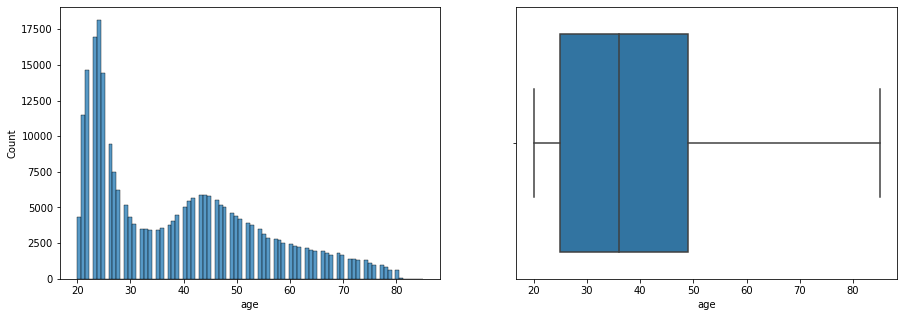

In [147]:
#Age  - Client Age
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.histplot(data=df4, x='age')
plt.subplot(1,2,2)
sns.boxplot(data=df4, x='age')

Como identificado na secção **1.4** a feature Age tem assimetria positiva indicando maior concentração no lado esquerdo do histograma na faixa de idade de 22 e 27 anos aproximadamente. Além de indicar que moda < mediana < média

<Axes: xlabel='annual_premium'>

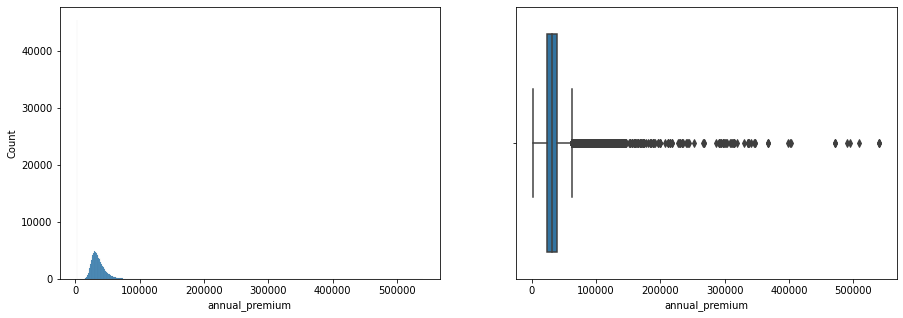

In [148]:
#Annual Premium
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.histplot(data=df4, x='annual_premium')
plt.subplot(1,2,2)
sns.boxplot(data=df4, x='annual_premium')

<Axes: xlabel='vintage'>

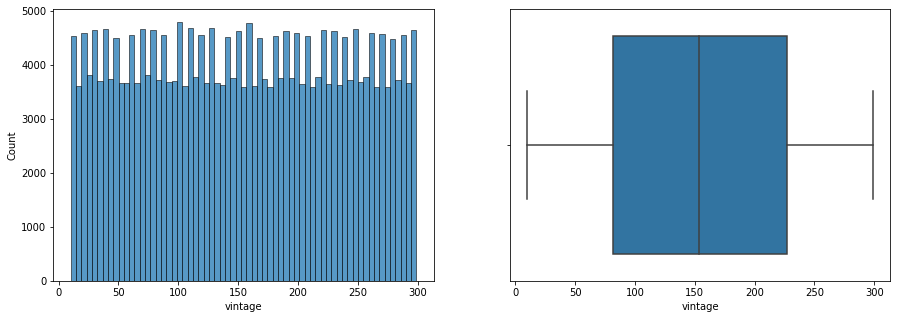

In [149]:
# Vintage 
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.histplot(data=df4, x='vintage')
plt.subplot(1,2,2)
sns.boxplot(data=df4, x='vintage')

### 4.1.2 Categorical Features

<Axes: xlabel='driving_license', ylabel='count'>

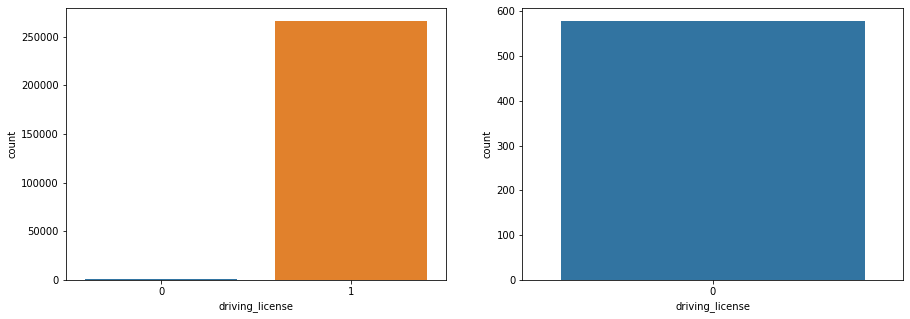

In [150]:
#Driving Licence
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(data=df4, x='driving_license')
plt.subplot(1,2,2)
aux = df4.loc[df4['driving_license'] == 0, :].reset_index()
# sns.countplot(data=aux, x='driving_license')
sns.countplot(data=aux, x='driving_license')


<Axes: xlabel='previously_insured', ylabel='count'>

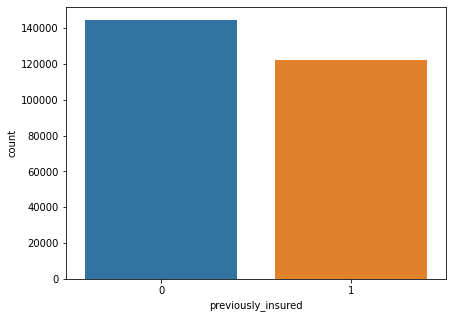

In [151]:
# previously_insured

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(data=df4, x='previously_insured')

<Axes: xlabel='gender', ylabel='count'>

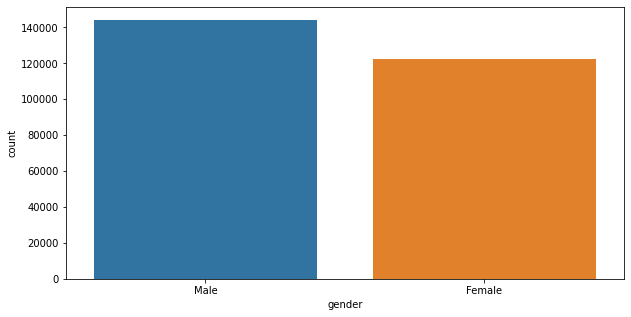

In [152]:
#gender
plt.figure(figsize=(10,5))
sns.countplot(data=df4, x= 'gender') 

<Axes: xlabel='vehicle_age', ylabel='count'>

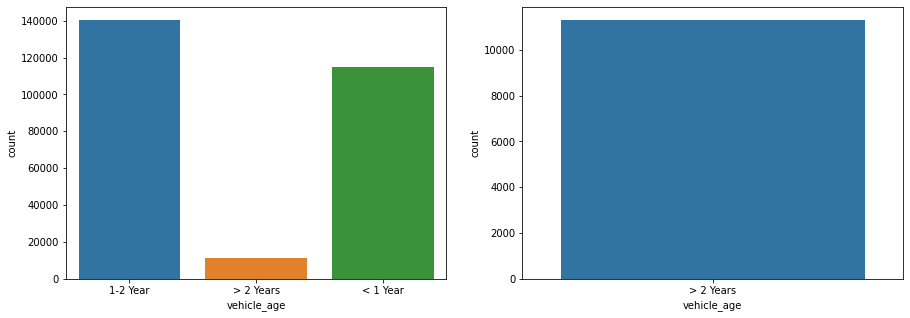

In [153]:
#vehicle_age
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(data=df4, x= 'vehicle_age') 
plt.subplot(1,2,2)
aux = df4.loc[df4['vehicle_age'] == '> 2 Years',:]
sns.countplot(data=aux, x='vehicle_age')

<Axes: xlabel='vehicle_damage', ylabel='count'>

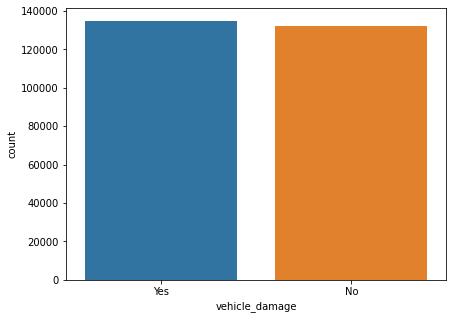

In [154]:
#vehicle_damage
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(data=df4, x= 'vehicle_damage')

<Axes: xlabel='response', ylabel='count'>

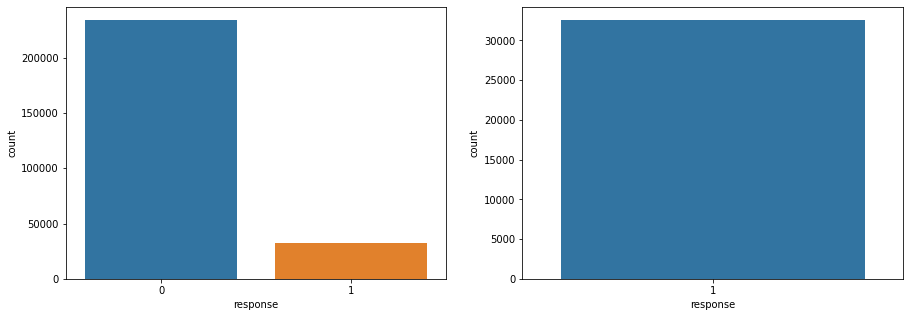

In [155]:
# Response

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(data=df4, x='response')
plt.subplot(1,2,2)
aux = df4.loc[df4['response'] == 1, :]
sns.countplot(data=aux, x='response')

## 4.2 Bivariate Analysis

### H3. Clientes com carros novos com menos de um ano contratariam o seguro veicular
 

<Axes: xlabel='vehicle_age', ylabel='response'>

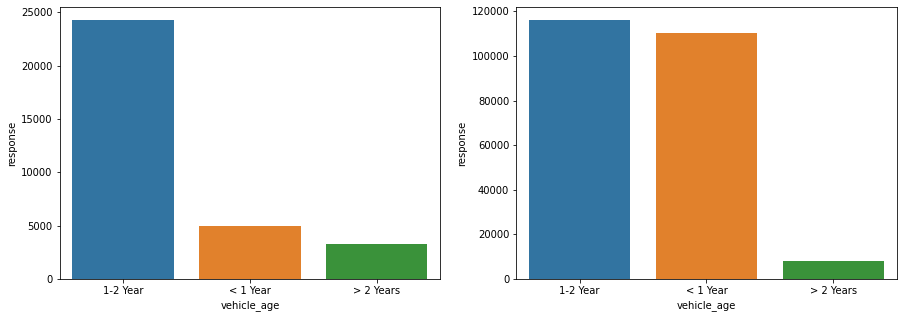

In [156]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
aux = df4.loc[df4['response'] == 1, ['response', 'vehicle_age']].groupby(['vehicle_age']).count().reset_index()
sns.barplot(data=aux, x='vehicle_age', y='response')
plt.subplot(1,2,2)
aux1 = df4.loc[df4['response'] == 0, ['response', 'vehicle_age']].groupby(['vehicle_age']).count().reset_index()
sns.barplot(data=aux1, x='vehicle_age', y='response')


In [157]:
total_response_v = len(df4.loc[df4['response'] == 1,:])
############## Para menos de um ano #################
total_less_oney = len(df4.loc[(df4['response'] == 1) & (df4['vehicle_age'] == '< 1 Year'),:])
percentage_less_oney = total_less_oney/total_response_v
print('Total de pessoas que contratariam o seguro veicular e o carro tem menos de um ano: {:.4f}'.format(percentage_less_oney))

############## Entre um e dois anos #################
total_less_oney = len(df4.loc[(df4['response'] == 1) & (df4['vehicle_age'] == '1-2 Year'),:])
percentage_bwt_onetwo = total_less_oney/total_response_v
print('Total de pessoas que contratariam o seguro veicular e o carro tem entre um e dois anos: {:.4f}'.format(percentage_bwt_onetwo))

Total de pessoas que contratariam o seguro veicular e o carro tem menos de um ano: 0.1537
Total de pessoas que contratariam o seguro veicular e o carro tem entre um e dois anos: 0.7452


Como apenas 15% das pessoas que tem o carro a menos de um ano contratariam o seguro a hipótese **H3** é falsa. Além disso, 74% das pessoas que contratariam o seguro tem o carro entre 1 e 2 anos.

### H4. Pessoas acima dos 30 anos contratariam o seguro veicular


/tmp/ipykernel_86345/2479584926.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['age_binned'] = pd.cut(aux['age'], bins)


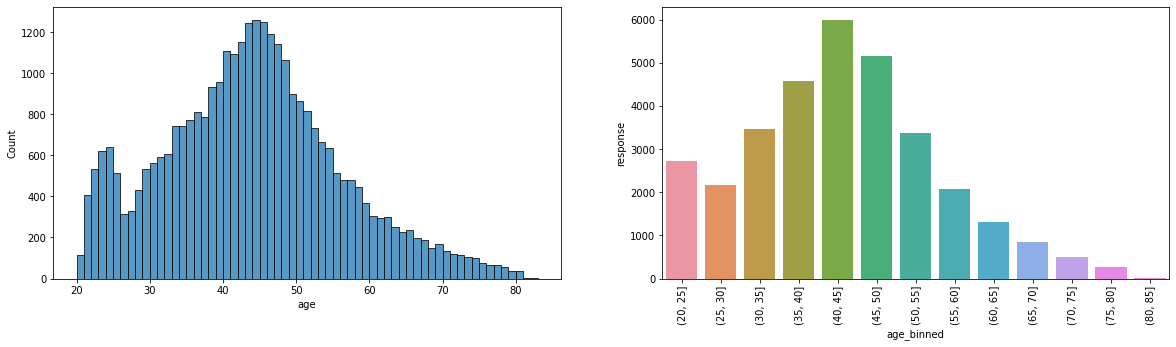

In [158]:
aux = df4.loc[df4['response'] == 1,:]
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.histplot(data=aux, x='age')
plt.subplot(1,2,2)
bins = np.arange(20,90,5)
aux['age_binned'] = pd.cut(aux['age'], bins)
aux2 = aux.loc[:, ['response', 'age_binned']].groupby(['age_binned']).sum().reset_index()
sns.barplot(data=aux2, x='age_binned',y='response')
plt.xticks(rotation=90);

In [175]:
less_30 =len(aux.loc[aux['age'] <30, : ])/len(aux)
higher_30 = len(aux.loc[aux['age'] >30, : ])/len(aux)
print('Total de pessoas que contratariam o seguro e tem mais de 30 anos: {:.4f}'.format(higher_30))
print('Total de pessoas que contratariam o seguro e tem menos de 30 anos: {:.4f}'.format(less_30))


Total de pessoas que contratariam o seguro e tem mais de 30 anos: 0.8462
Total de pessoas que contratariam o seguro e tem menos de 30 anos: 0.1364


Hipótese é **verdadeira**, aproximadamente 85% das pessoas que contratariam o seguro tem mais de 30 anos de idade

### H5. Clientes cujo veículo já sofreu danos contratariam o seguro veicular

In [189]:
df4['vehicle_damage'].value_counts(normalize=True)

vehicle_damage
Yes    0.5053
No     0.4947
Name: proportion, dtype: float64

### H6. Somente clientes habilitados contratariam o seguro veicular


In [190]:
df4['driving_license'].value_counts(normalize=True)

driving_license
1    0.997833
0    0.002167
Name: proportion, dtype: float64

Hipótese verdadeira, 99,7% dos clientes que contratariam o seguro são habilitados.

### H7. Clientes mais antigos da seguradora contratariam o seguro veicular


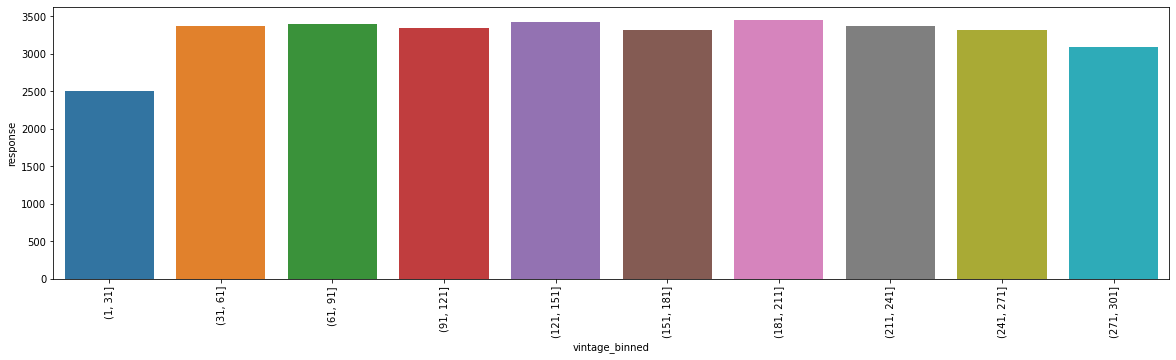

In [210]:
aux = df4.loc[df4['response'] == 1, ['response', 'vintage']]
plt.figure(figsize=(20,5))
bins = np.arange(1,320,30)
aux['vintage_binned'] = pd.cut(aux['vintage'], bins = bins)
aux2 = aux.loc[:, ['response','vintage_binned']].groupby(['vintage_binned']).sum().reset_index()
sns.barplot(data=aux2,x='vintage_binned', y='response')
plt.xticks(rotation=90);


## 4.3 Multivariate Analysis

<Axes: >

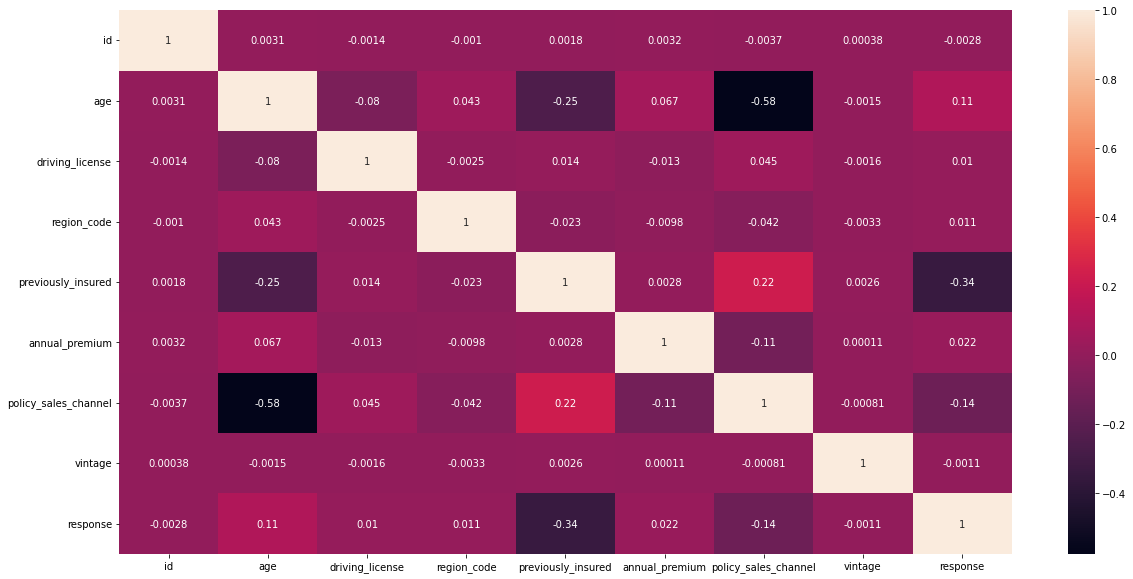

In [211]:

plt.figure(figsize=(20,10))
sns.heatmap(numerical_features.corr('pearson'), annot=True)



# 5.0 Data Preparation

In [212]:
df5 = df4.copy()

# 6.0 Feature Selection